## 异常数据检测（2019.7.19 Workshop）

- 时间16:30\-17:30，地点26楼【C++】会议室
- 内容
    - 异常数据的定义、应用与检测方法
    - lbs网站数据中异常数据的检测与清洗
- 形式与时间分配
    - 30-40分钟介绍背景、原理，以及工作中的实际项目应用
    - 20-30分钟大家自己写代码进行实践，以及问题讨论
- 所需环境：Python3, Jupyter Notebook (其他工具包安装较快，可以现场装)

### 背景
- 数据工程的链路
    - 获取，预处理，分析与挖掘，终端数据产品
- 异常数据
    - 与"空数据"、"错误数据"，三者的联系与区别是什么？
- [常见数据分布类型](./Distribution%20Patterns.ipynb)
    - 正态分布
    - 指数分布
    - 二项分布
- 异常数据的检测算法
    - 高斯椭圆包络 [Robust Gaussian](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html)
    - 单类型支持向量机 [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)
    - 孤立森林 [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
    - 局部异常因子 [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

### 异常数据检测的应用
- 用于预处理：脏数据、可疑数据的清洗
- 作为研究对象本身
    - 服务端反爬虫
    - 特殊人群识别（如：电商刷单用户，人群中潜在的小偷或嫌疑人）
    - 反欺诈（如：信用卡防盗刷，账号防盗）

### 工具包安装

In [14]:
import pickle, math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.covariance import EllipticEnvelope
from ipywidgets import interact, widgets
import pandas as pd
plt.style.use('ggplot')
import bokeh.plotting as bkh
from bokeh.palettes import Category20
bkh.output_notebook()
%config InlineBackend.figure_format ='retina'

Loading BokehJS ...

In [2]:
df = pd.read_pickle('sh_top_buss.p')

#### pandas的简单应用
- describe, head, tail, sample
- query, count, value_counts, groupby (类似简化版的SQL)

In [4]:
buss_list = df['buss'].unique()

In [5]:
buss_list

array(['静安寺', '南京西路', '漕河泾/田林', '徐家汇', '九亭', '惠南镇', '南桥', '七宝', '川沙',
       '淮海路', '中山公园', '松江镇', '江桥', '金山卫', '庙行/共康', '张江', '金桥', '五角场/大学区',
       '大华地区', '康桥/周浦'], dtype=object)

### 商圈静态图

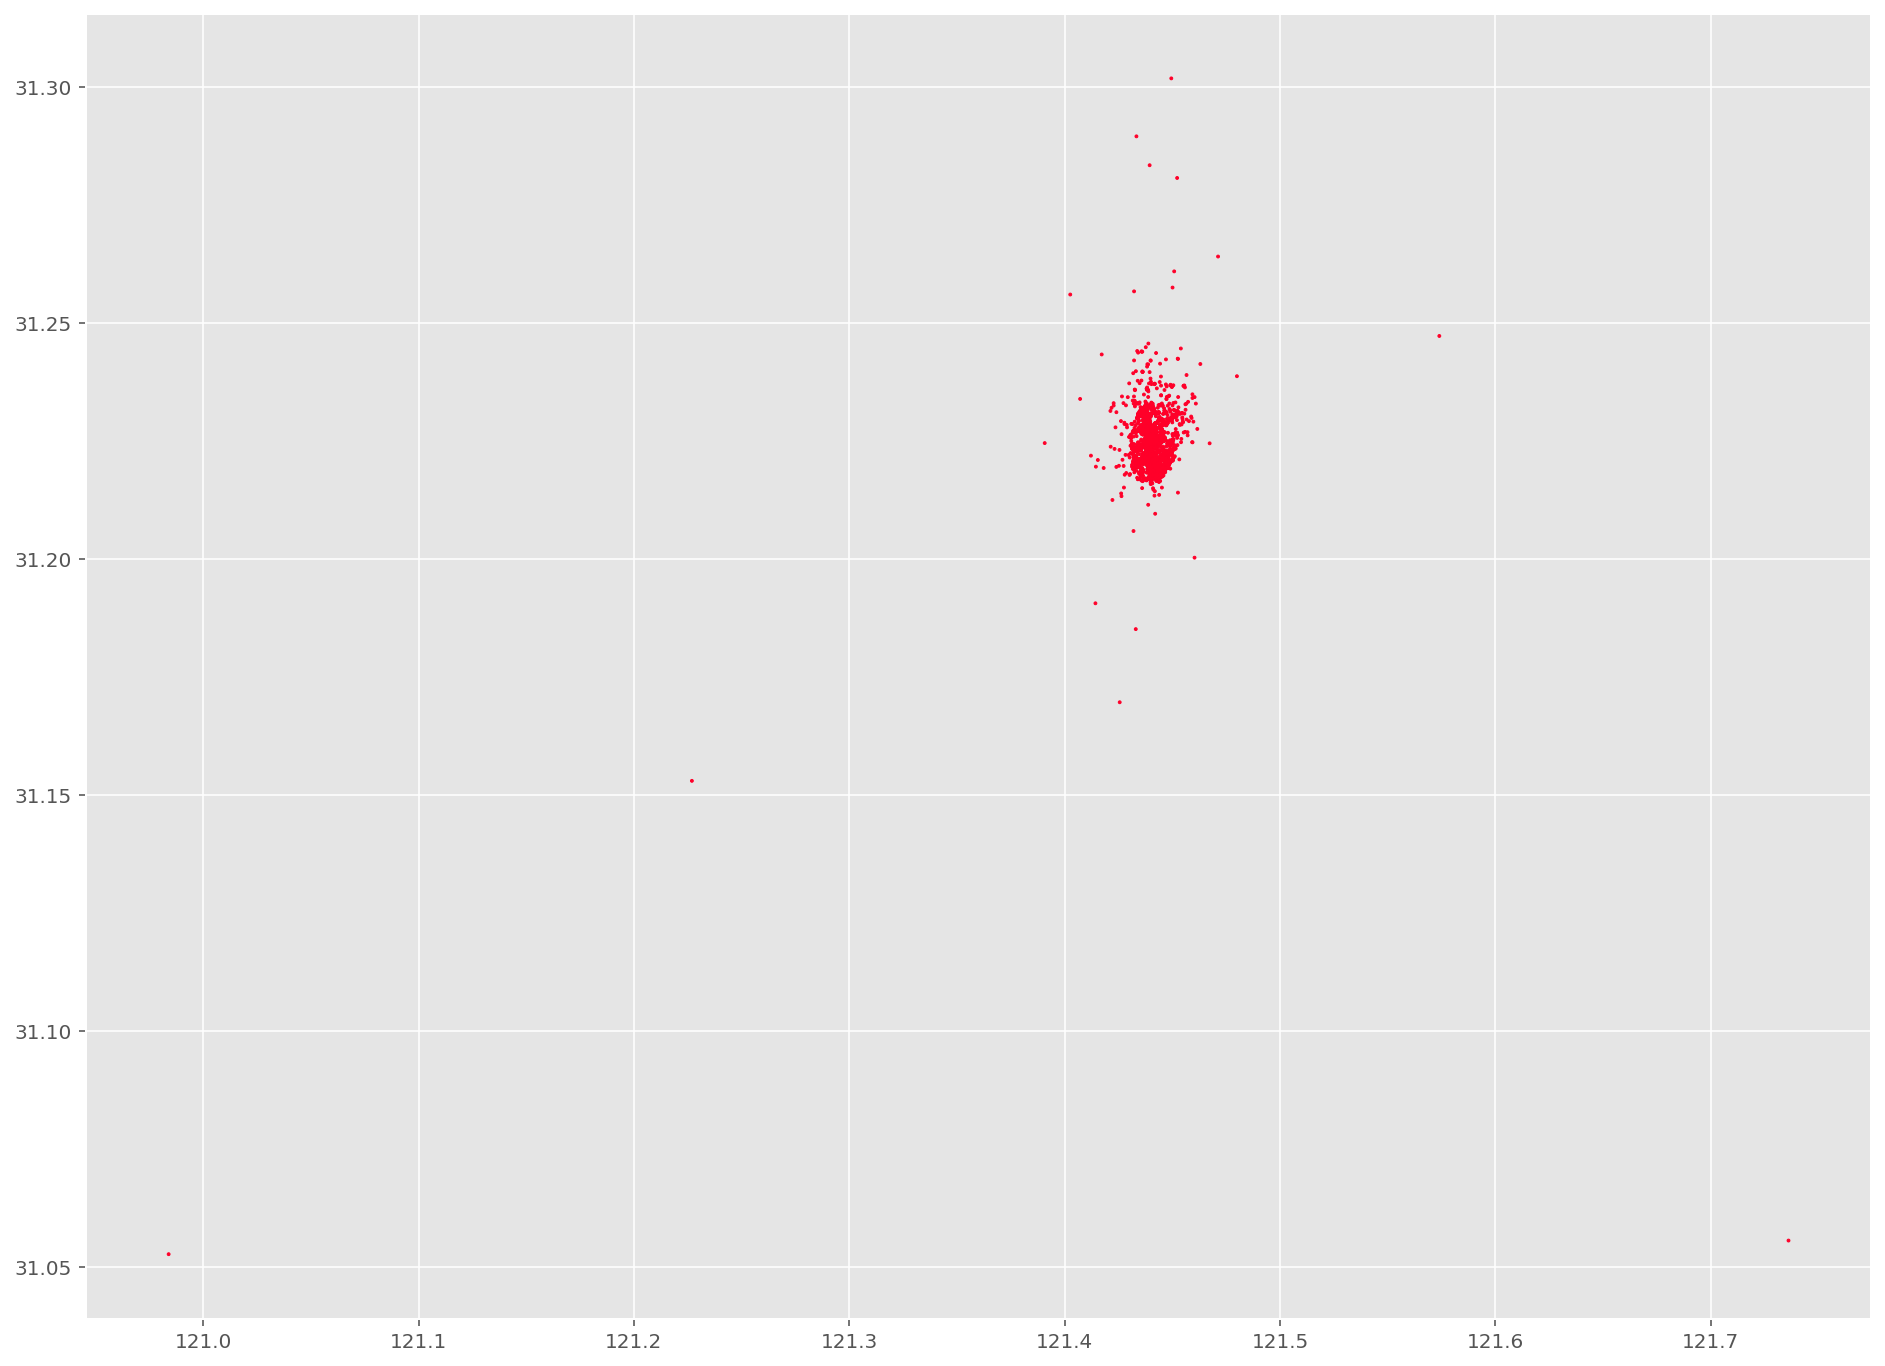

In [6]:
plt.figure(figsize=(16,12))
plt.scatter(df.query('buss=="静安寺"')['x'], df.query('buss=="静安寺"')['y'], s=2, 
            c=df.query('buss=="静安寺"')['buss'].map(lambda x: np.where(buss_list == x)[0][0]), cmap='gist_rainbow');
plt.show()

### 交互式图表

In [7]:
def join_buss_query(buss_name_list):
    return ' | '.join(list(map(lambda x: 'buss=="%s"' %x, buss_name_list)))

In [8]:
def plot_interactive(buss_name_list):
    global df
    q = join_buss_query(buss_name_list)
    df_buss = df.query(q)
    f = bkh.figure(width=960, height=720)
    f.circle(df_buss['x'], df_buss['y'],
             fill_color=df_buss['buss'].map(lambda x: Category20[20][np.where(buss_list == x)[0][0]]),
             line_color=df_buss['buss'].map(lambda x: Category20[20][np.where(buss_list == x)[0][0]]),
             size=3,
             alpha=.6
            )
    bkh.show(f)

In [9]:
interact(
    plot_interactive,
    buss_name_list=widgets.SelectMultiple(value=['静安寺'], options=buss_list),
    contam=widgets.FloatText(value=0.01, min=0, max=1, step=0.01)
);

interactive(children=(SelectMultiple(description='buss_name_list', index=(0,), options=('静安寺', '南京西路', '漕河泾/田林…

### 基于Robust Gaussian方法
- 椭圆包络线(高斯椭圆包络)

In [10]:
def test(**kwargs):
#     a,b = *kwargs
    for key, value in kwargs.items():
        print('%s==%s' %(key, value))
#     print(kwargs['a'], kwargs['b'])
    
def test_call(a=1,b=2):
    test(a=1,b=2)
    
test_call()

a==1
b==2


In [11]:
from sklearn.svm import OneClassSVM

In [16]:

def filter_one_buss(df, **kwargs):
    X = np.array((df['x'], df['y'])).T
#     outlier_clf = EllipticEnvelope(contamination=kwargs['contam'])
    outlier_clf = OneClassSVM(nu=kwargs['nu'], gamma=kwargs['gamma'])
    
    outlier_clf.fit(X)
    return df[outlier_clf.predict(X)==1], df[outlier_clf.predict(X)==-1], outlier_clf

@interact(
    buss_name=widgets.Select(value='静安寺', options=buss_list),
#     contam=widgets.FloatText(value=0.05, min=0, max=10, step=0.001),
    nu=widgets.FloatText(value=0.1, min=0, max=10, step=0.1),
    gamma=widgets.FloatText(value=0.1, min=0, max=10, step=0.1),
)
def visualize_detection(buss_name, **kwargs):
    global df
    df_buss = df[df['buss']==buss_name]
    df_valid, df_outlier, outlier_clf = filter_one_buss(df_buss, **kwargs)
    
    X_valid = np.array((df_valid['x'], df_valid['y'])).T
    X_outlier = np.array((df_outlier['x'], df_outlier['y'])).T
    plt.figure(figsize=(12,10))
    plt.scatter(X_valid[:,0], X_valid[:,1], s=2, c='g')
    plt.scatter(X_outlier[:,0], X_outlier[:,1], s=2, c='r')
    # 使用等高线图画出决策边界
    xx, yy = np.meshgrid(
        np.linspace(df_buss['x'].min(), df_buss['x'].max(), 100), 
        np.linspace(df_buss['y'].min(), df_buss['y'].max(), 100))
    zz = outlier_clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=[0], linewidths=1.5, colors='k')
    plt.show()

interactive(children=(Select(description='buss_name', options=('静安寺', '南京西路', '漕河泾/田林', '徐家汇', '九亭', '惠南镇', '南…

## Worshop Session & Discussion
- Session1:
对高斯椭圆包络线的效果进行调试与优化
- Session2:
换用其他检测算法进行异常数据检测，并对比检测效果